In [1]:
import h5py
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import csv
import time
from sklearn.metrics import hamming_loss
from sklearn.metrics import confusion_matrix

In [3]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Flatten, Reshape, Dropout
from keras.layers.convolutional import Conv2D, UpSampling2D,Cropping2D,ZeroPadding2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate, Add
from keras.layers import Input
from keras.models import Sequential
from keras import optimizers
from keras import losses
from keras import metrics
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import matplotlib.pyplot as plt
import keras.backend as K
import keras
%matplotlib inline

Using TensorFlow backend.


In [4]:
# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.3

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

# Importing Data

In [5]:
import numpy as np
import h5py
P = h5py.File('Gaze_Onesec_dataset.hdf5','r')

# Gaze Data

In [6]:
gaze_train = P['Training_Set/Total_Gaze']
gaze_test = P['Testing_Set/Total_Gaze']
gaze_valid = P['Validation_Set/Total_Gaze']

# Label Data

In [7]:
label_train = P['Training_Set/Total_Label']
label_test = P['Testing_Set/Total_Label']
label_validation = P['Validation_Set/Total_Label']

# Training, Validation & Test Data - Gaze

In [8]:
gaze_train = gaze_train[:,:,(1,2,3,4)]
(l,m,n) = gaze_train.shape
gaze_train = np.reshape(gaze_train,(l,m,n,1))

gaze_test = gaze_test[:,:,(1,2,3,4)]
(p,q,r) = gaze_test.shape
gaze_test= np.reshape(gaze_test,(p,q,r,1))

gaze_valid = gaze_valid[:,:,(1,2,3,4)]
(p,q,r) = gaze_valid.shape
gaze_valid= np.reshape(gaze_valid,(p,q,r,1))

gaze_train.shape, gaze_test.shape,  gaze_valid.shape

((227146, 30, 4, 1), (67648, 30, 4, 1), (29731, 30, 4, 1))

# Training, Validation & Test Data - Label

In [9]:
label_train = label_train[:,(1,2,3,4,5,6,7,8,9)]

label_test = label_test[:,(1,2,3,4,5,6,7,8,9)]

label_valid= label_valid[:,(1,2,3,4,5,6,7,8,9)]

label_train.shape,label_test.shape,label_valid.shape

((227146, 9), (67648, 9), (29731, 9))

# Model input & output shape

In [10]:
input_shape1 = (30,4,1)
out_nodes = 9

# CNN Model

In [22]:

opti =optimizers.Adam(lr=0.001)

Gazeinput = Input(shape=input_shape1)

conv1 = Conv2D(8, kernel_size=(3,1), activation='relu')(Gazeinput)

conv2 = Conv2D(16, kernel_size=(3,1), activation='relu')(conv1)

flat2 = Flatten()(conv2)

# interpretation model

hid0 = Dense(32, activation='relu')(flat2)

hid1 = Dense(16, activation='relu')(hid0)

output = Dense(9, activation='sigmoid')(hid1)

model = Model(inputs=Gazeinput, outputs=output)

# summarize layers
print(model.summary())

def multitask_loss(y_true, y_pred):
    
            # Avoid divide by 0
    
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            
            # Multi-task loss
            
            return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))
        
model.compile(optimizer=opti, loss=multitask_loss,metrics = [multitask_loss, "categorical_crossentropy" ,'accuracy']) 


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 14.1 µs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30, 4, 1)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 4, 8)          32        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 4, 16)         400       
_________________________________________________________________
flatten_3 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                53280     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10

# Model History

In [23]:
history = model.fit(gaze_train, label_train,
          batch_size=512,
          epochs=1000,
          verbose=1, shuffle = True, validation_data = (gaze_valid, label_valid))

print(history)

Train on 227146 samples, validate on 29731 samples
Epoch 1/1000
227146/227146 [==============================] - 5s 22us/step - loss: 3.9285 - multitask_loss: 3.9285 - categorical_crossentropy: 3.3777 - acc: 0.2280 - val_loss: 4.9015 - val_multitask_loss: 4.9015 - val_categorical_crossentropy: 4.5931 - val_acc: 0.0851
Epoch 2/1000
227146/227146 [==============================] - 4s 19us/step - loss: 3.5397 - multitask_loss: 3.5397 - categorical_crossentropy: 3.1223 - acc: 0.2772 - val_loss: 4.8274 - val_multitask_loss: 4.8274 - val_categorical_crossentropy: 4.5452 - val_acc: 0.0848
Epoch 3/1000
227146/227146 [==============================] - 4s 20us/step - loss: 3.4209 - multitask_loss: 3.4209 - categorical_crossentropy: 3.0368 - acc: 0.2990 - val_loss: 4.9662 - val_multitask_loss: 4.9662 - val_categorical_crossentropy: 4.6466 - val_acc: 0.0981
Epoch 4/1000
227146/227146 [==============================] - 4s 19us/step - loss: 3.3419 - multitask_loss: 3.3419 - categorical_crossentropy:

227146/227146 [==============================] - 4s 20us/step - loss: 2.9388 - multitask_loss: 2.9388 - categorical_crossentropy: 2.7125 - acc: 0.3414 - val_loss: 4.9073 - val_multitask_loss: 4.9073 - val_categorical_crossentropy: 4.6254 - val_acc: 0.1083
Epoch 62/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.9381 - multitask_loss: 2.9381 - categorical_crossentropy: 2.7115 - acc: 0.3425 - val_loss: 4.8622 - val_multitask_loss: 4.8622 - val_categorical_crossentropy: 4.5976 - val_acc: 0.1136
Epoch 63/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.9372 - multitask_loss: 2.9372 - categorical_crossentropy: 2.7110 - acc: 0.3421 - val_loss: 4.9452 - val_multitask_loss: 4.9452 - val_categorical_crossentropy: 4.6467 - val_acc: 0.1061
Epoch 64/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.9354 - multitask_loss: 2.9354 - categorical_crossentropy: 2.7100 - acc: 0.3424 - val_loss: 4.9682 - val_multitask_loss

227146/227146 [==============================] - 4s 18us/step - loss: 2.8506 - multitask_loss: 2.8506 - categorical_crossentropy: 2.6555 - acc: 0.3557 - val_loss: 4.9304 - val_multitask_loss: 4.9304 - val_categorical_crossentropy: 4.6464 - val_acc: 0.1073
Epoch 144/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.8495 - multitask_loss: 2.8495 - categorical_crossentropy: 2.6548 - acc: 0.3541 - val_loss: 4.9493 - val_multitask_loss: 4.9493 - val_categorical_crossentropy: 4.6467 - val_acc: 0.1092
Epoch 145/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.8509 - multitask_loss: 2.8509 - categorical_crossentropy: 2.6555 - acc: 0.3556 - val_loss: 4.9041 - val_multitask_loss: 4.9041 - val_categorical_crossentropy: 4.6367 - val_acc: 0.1087
Epoch 146/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.8495 - multitask_loss: 2.8495 - categorical_crossentropy: 2.6544 - acc: 0.3551 - val_loss: 5.0033 - val_multitask_l

227146/227146 [==============================] - 4s 18us/step - loss: 2.8173 - multitask_loss: 2.8173 - categorical_crossentropy: 2.6340 - acc: 0.3593 - val_loss: 4.9671 - val_multitask_loss: 4.9671 - val_categorical_crossentropy: 4.6802 - val_acc: 0.1169
Epoch 209/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.8146 - multitask_loss: 2.8146 - categorical_crossentropy: 2.6325 - acc: 0.3600 - val_loss: 5.0292 - val_multitask_loss: 5.0292 - val_categorical_crossentropy: 4.6858 - val_acc: 0.1144
Epoch 210/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.8123 - multitask_loss: 2.8123 - categorical_crossentropy: 2.6308 - acc: 0.3592 - val_loss: 4.9302 - val_multitask_loss: 4.9302 - val_categorical_crossentropy: 4.6509 - val_acc: 0.1229
Epoch 211/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.8125 - multitask_loss: 2.8125 - categorical_crossentropy: 2.6311 - acc: 0.3605 - val_loss: 4.9685 - val_multitask_l

227146/227146 [==============================] - 4s 17us/step - loss: 2.7892 - multitask_loss: 2.7892 - categorical_crossentropy: 2.6164 - acc: 0.3624 - val_loss: 4.9896 - val_multitask_loss: 4.9896 - val_categorical_crossentropy: 4.6916 - val_acc: 0.1140
Epoch 269/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7865 - multitask_loss: 2.7865 - categorical_crossentropy: 2.6150 - acc: 0.3629 - val_loss: 5.0504 - val_multitask_loss: 5.0504 - val_categorical_crossentropy: 4.6914 - val_acc: 0.1099
Epoch 270/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.7864 - multitask_loss: 2.7864 - categorical_crossentropy: 2.6148 - acc: 0.3620 - val_loss: 5.0206 - val_multitask_loss: 5.0206 - val_categorical_crossentropy: 4.6917 - val_acc: 0.1112
Epoch 271/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.7857 - multitask_loss: 2.7857 - categorical_crossentropy: 2.6141 - acc: 0.3639 - val_loss: 4.9640 - val_multitask_l

227146/227146 [==============================] - 4s 19us/step - loss: 2.7661 - multitask_loss: 2.7661 - categorical_crossentropy: 2.6021 - acc: 0.3647 - val_loss: 5.1399 - val_multitask_loss: 5.1399 - val_categorical_crossentropy: 4.7819 - val_acc: 0.1105
Epoch 329/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.7706 - multitask_loss: 2.7706 - categorical_crossentropy: 2.6047 - acc: 0.3650 - val_loss: 5.1177 - val_multitask_loss: 5.1177 - val_categorical_crossentropy: 4.7552 - val_acc: 0.1058
Epoch 330/1000
227146/227146 [==============================] - 4s 20us/step - loss: 2.7660 - multitask_loss: 2.7660 - categorical_crossentropy: 2.6022 - acc: 0.3644 - val_loss: 5.0381 - val_multitask_loss: 5.0381 - val_categorical_crossentropy: 4.7177 - val_acc: 0.1084
Epoch 331/1000
227146/227146 [==============================] - 4s 20us/step - loss: 2.7683 - multitask_loss: 2.7683 - categorical_crossentropy: 2.6034 - acc: 0.3658 - val_loss: 5.1319 - val_multitask_l

227146/227146 [==============================] - 4s 19us/step - loss: 2.7538 - multitask_loss: 2.7538 - categorical_crossentropy: 2.5948 - acc: 0.3671 - val_loss: 5.1344 - val_multitask_loss: 5.1344 - val_categorical_crossentropy: 4.7971 - val_acc: 0.1113
Epoch 389/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7521 - multitask_loss: 2.7521 - categorical_crossentropy: 2.5937 - acc: 0.3659 - val_loss: 5.2025 - val_multitask_loss: 5.2025 - val_categorical_crossentropy: 4.8172 - val_acc: 0.1125
Epoch 390/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7534 - multitask_loss: 2.7534 - categorical_crossentropy: 2.5944 - acc: 0.3662 - val_loss: 5.1167 - val_multitask_loss: 5.1167 - val_categorical_crossentropy: 4.7574 - val_acc: 0.1102
Epoch 391/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7517 - multitask_loss: 2.7517 - categorical_crossentropy: 2.5931 - acc: 0.3653 - val_loss: 5.1248 - val_multitask_l

227146/227146 [==============================] - 4s 20us/step - loss: 2.7399 - multitask_loss: 2.7399 - categorical_crossentropy: 2.5861 - acc: 0.3674 - val_loss: 5.2366 - val_multitask_loss: 5.2366 - val_categorical_crossentropy: 4.8180 - val_acc: 0.1021
Epoch 449/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.7399 - multitask_loss: 2.7399 - categorical_crossentropy: 2.5861 - acc: 0.3679 - val_loss: 5.2226 - val_multitask_loss: 5.2226 - val_categorical_crossentropy: 4.8281 - val_acc: 0.1178
Epoch 450/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.7407 - multitask_loss: 2.7407 - categorical_crossentropy: 2.5865 - acc: 0.3677 - val_loss: 5.0430 - val_multitask_loss: 5.0430 - val_categorical_crossentropy: 4.7104 - val_acc: 0.1098
Epoch 451/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7389 - multitask_loss: 2.7389 - categorical_crossentropy: 2.5854 - acc: 0.3684 - val_loss: 5.2475 - val_multitask_l

227146/227146 [==============================] - 4s 18us/step - loss: 2.7250 - multitask_loss: 2.7250 - categorical_crossentropy: 2.5771 - acc: 0.3690 - val_loss: 5.1515 - val_multitask_loss: 5.1515 - val_categorical_crossentropy: 4.7888 - val_acc: 0.1123
Epoch 528/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.7289 - multitask_loss: 2.7289 - categorical_crossentropy: 2.5796 - acc: 0.3678 - val_loss: 5.1890 - val_multitask_loss: 5.1890 - val_categorical_crossentropy: 4.7977 - val_acc: 0.1111
Epoch 529/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.7266 - multitask_loss: 2.7266 - categorical_crossentropy: 2.5779 - acc: 0.3696 - val_loss: 5.1690 - val_multitask_loss: 5.1690 - val_categorical_crossentropy: 4.7878 - val_acc: 0.1168
Epoch 530/1000
 29184/227146 [==>...........................] - ETA: 3s - loss: 2.6972 - multitask_loss: 2.6972 - categorical_crossentropy: 2.5452 - acc: 0.3723

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



227146/227146 [==============================] - 4s 17us/step - loss: 2.7232 - multitask_loss: 2.7232 - categorical_crossentropy: 2.5758 - acc: 0.3697 - val_loss: 5.3001 - val_multitask_loss: 5.3001 - val_categorical_crossentropy: 4.8676 - val_acc: 0.1030
Epoch 557/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.7228 - multitask_loss: 2.7228 - categorical_crossentropy: 2.5756 - acc: 0.3685 - val_loss: 5.2164 - val_multitask_loss: 5.2164 - val_categorical_crossentropy: 4.8433 - val_acc: 0.1163
Epoch 558/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.7215 - multitask_loss: 2.7215 - categorical_crossentropy: 2.5747 - acc: 0.3702 - val_loss: 5.1282 - val_multitask_loss: 5.1282 - val_categorical_crossentropy: 4.7911 - val_acc: 0.1179
Epoch 559/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7239 - multitask_loss: 2.7239 - categorical_crossentropy: 2.5766 - acc: 0.3685 - val_loss: 5.2309 - val_multitask_l

227146/227146 [==============================] - 4s 18us/step - loss: 2.7137 - multitask_loss: 2.7137 - categorical_crossentropy: 2.5702 - acc: 0.3694 - val_loss: 5.1568 - val_multitask_loss: 5.1568 - val_categorical_crossentropy: 4.7741 - val_acc: 0.1085
Epoch 617/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7179 - multitask_loss: 2.7179 - categorical_crossentropy: 2.5726 - acc: 0.3708 - val_loss: 5.1544 - val_multitask_loss: 5.1544 - val_categorical_crossentropy: 4.7879 - val_acc: 0.1060
Epoch 618/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.7132 - multitask_loss: 2.7132 - categorical_crossentropy: 2.5698 - acc: 0.3707 - val_loss: 5.2467 - val_multitask_loss: 5.2467 - val_categorical_crossentropy: 4.8354 - val_acc: 0.1029
Epoch 619/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.7149 - multitask_loss: 2.7149 - categorical_crossentropy: 2.5710 - acc: 0.3700 - val_loss: 5.1692 - val_multitask_l

227146/227146 [==============================] - 4s 17us/step - loss: 2.7070 - multitask_loss: 2.7070 - categorical_crossentropy: 2.5661 - acc: 0.3707 - val_loss: 5.2635 - val_multitask_loss: 5.2635 - val_categorical_crossentropy: 4.8757 - val_acc: 0.1100
Epoch 677/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.7063 - multitask_loss: 2.7063 - categorical_crossentropy: 2.5660 - acc: 0.3713 - val_loss: 5.3821 - val_multitask_loss: 5.3821 - val_categorical_crossentropy: 4.9506 - val_acc: 0.1037
Epoch 678/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7056 - multitask_loss: 2.7056 - categorical_crossentropy: 2.5655 - acc: 0.3711 - val_loss: 5.2376 - val_multitask_loss: 5.2376 - val_categorical_crossentropy: 4.8472 - val_acc: 0.1112
Epoch 679/1000
227146/227146 [==============================] - 5s 20us/step - loss: 2.7071 - multitask_loss: 2.7071 - categorical_crossentropy: 2.5661 - acc: 0.3709 - val_loss: 5.2867 - val_multitask_l

227146/227146 [==============================] - 4s 18us/step - loss: 2.7014 - multitask_loss: 2.7014 - categorical_crossentropy: 2.5631 - acc: 0.3700 - val_loss: 5.1720 - val_multitask_loss: 5.1720 - val_categorical_crossentropy: 4.8006 - val_acc: 0.1137
Epoch 737/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.6987 - multitask_loss: 2.6987 - categorical_crossentropy: 2.5614 - acc: 0.3707 - val_loss: 5.2186 - val_multitask_loss: 5.2186 - val_categorical_crossentropy: 4.8387 - val_acc: 0.1095
Epoch 738/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.7007 - multitask_loss: 2.7007 - categorical_crossentropy: 2.5628 - acc: 0.3702 - val_loss: 5.2313 - val_multitask_loss: 5.2313 - val_categorical_crossentropy: 4.8487 - val_acc: 0.1058
Epoch 739/1000
227146/227146 [==============================] - 4s 18us/step - loss: 2.6977 - multitask_loss: 2.6977 - categorical_crossentropy: 2.5606 - acc: 0.3706 - val_loss: 5.1780 - val_multitask_l

227146/227146 [==============================] - 4s 19us/step - loss: 2.6942 - multitask_loss: 2.6942 - categorical_crossentropy: 2.5586 - acc: 0.3710 - val_loss: 5.3102 - val_multitask_loss: 5.3102 - val_categorical_crossentropy: 4.8986 - val_acc: 0.1051
Epoch 797/1000
227146/227146 [==============================] - 5s 20us/step - loss: 2.6938 - multitask_loss: 2.6938 - categorical_crossentropy: 2.5583 - acc: 0.3718 - val_loss: 5.1634 - val_multitask_loss: 5.1634 - val_categorical_crossentropy: 4.8080 - val_acc: 0.1086
Epoch 798/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.6944 - multitask_loss: 2.6944 - categorical_crossentropy: 2.5586 - acc: 0.3703 - val_loss: 5.4145 - val_multitask_loss: 5.4145 - val_categorical_crossentropy: 4.9512 - val_acc: 0.1008
Epoch 799/1000
227146/227146 [==============================] - 5s 20us/step - loss: 2.6911 - multitask_loss: 2.6911 - categorical_crossentropy: 2.5563 - acc: 0.3710 - val_loss: 5.3913 - val_multitask_l

227146/227146 [==============================] - 5s 20us/step - loss: 2.6901 - multitask_loss: 2.6901 - categorical_crossentropy: 2.5560 - acc: 0.3697 - val_loss: 5.2365 - val_multitask_loss: 5.2365 - val_categorical_crossentropy: 4.8500 - val_acc: 0.1074
Epoch 857/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.6853 - multitask_loss: 2.6853 - categorical_crossentropy: 2.5532 - acc: 0.3702 - val_loss: 5.3424 - val_multitask_loss: 5.3424 - val_categorical_crossentropy: 4.8729 - val_acc: 0.1106
Epoch 858/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.6873 - multitask_loss: 2.6873 - categorical_crossentropy: 2.5542 - acc: 0.3707 - val_loss: 5.2852 - val_multitask_loss: 5.2852 - val_categorical_crossentropy: 4.8745 - val_acc: 0.1136
Epoch 859/1000
227146/227146 [==============================] - 4s 19us/step - loss: 2.6868 - multitask_loss: 2.6868 - categorical_crossentropy: 2.5542 - acc: 0.3709 - val_loss: 5.3549 - val_multitask_l

227146/227146 [==============================] - 4s 18us/step - loss: 2.6824 - multitask_loss: 2.6824 - categorical_crossentropy: 2.5518 - acc: 0.3702 - val_loss: 5.2948 - val_multitask_loss: 5.2948 - val_categorical_crossentropy: 4.8864 - val_acc: 0.1038
Epoch 917/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.6826 - multitask_loss: 2.6826 - categorical_crossentropy: 2.5518 - acc: 0.3709 - val_loss: 5.3624 - val_multitask_loss: 5.3624 - val_categorical_crossentropy: 4.9323 - val_acc: 0.1030
Epoch 918/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.6827 - multitask_loss: 2.6827 - categorical_crossentropy: 2.5520 - acc: 0.3718 - val_loss: 5.2469 - val_multitask_loss: 5.2469 - val_categorical_crossentropy: 4.8518 - val_acc: 0.1069
Epoch 919/1000
227146/227146 [==============================] - 4s 17us/step - loss: 2.6840 - multitask_loss: 2.6840 - categorical_crossentropy: 2.5527 - acc: 0.3714 - val_loss: 5.2829 - val_multitask_l

227146/227146 [==============================] - 4s 20us/step - loss: 2.6777 - multitask_loss: 2.6777 - categorical_crossentropy: 2.5488 - acc: 0.3708 - val_loss: 5.2509 - val_multitask_loss: 5.2509 - val_categorical_crossentropy: 4.8499 - val_acc: 0.1019
Epoch 977/1000
227146/227146 [==============================] - 5s 20us/step - loss: 2.6790 - multitask_loss: 2.6790 - categorical_crossentropy: 2.5492 - acc: 0.3710 - val_loss: 5.3205 - val_multitask_loss: 5.3205 - val_categorical_crossentropy: 4.8771 - val_acc: 0.1129
Epoch 978/1000
227146/227146 [==============================] - 5s 21us/step - loss: 2.6771 - multitask_loss: 2.6771 - categorical_crossentropy: 2.5483 - acc: 0.3704 - val_loss: 5.2582 - val_multitask_loss: 5.2582 - val_categorical_crossentropy: 4.8673 - val_acc: 0.1045
Epoch 979/1000
227146/227146 [==============================] - 5s 20us/step - loss: 2.6775 - multitask_loss: 2.6775 - categorical_crossentropy: 2.5485 - acc: 0.3711 - val_loss: 5.3108 - val_multitask_l

# Hamming Loss

In [24]:
result1 = model.predict([gaze_test])
result = result1
result[result>=0.5] =1
result[result<0.5] =0
print(hamming_loss(label_test,result))


0.25183958793230315


 # Plots
 
 # Loss 

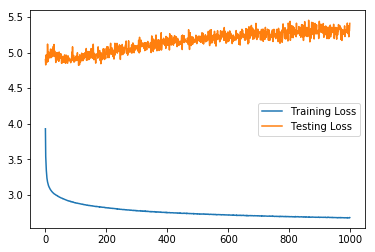

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Testing Loss")

plt.legend()
                                                    

# Accuracy

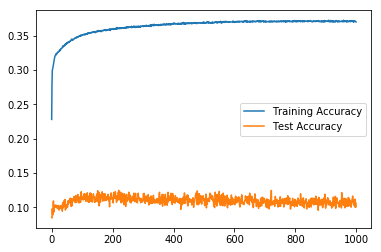

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label="Training Accuracy")
plt.plot(history.history['val_acc'], label="Test Accuracy")

plt.legend()



# Confusion Matrix

# Percentage

In [28]:
#Confusion matrix of each activity

print("Activity 1")
a = confusion_matrix(label_tes[:,0], result[:,0])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 2")
a = confusion_matrix(label_tes[:,1], result[:,1])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 3")
a = confusion_matrix(label_tes[:,2], result[:,2])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 4")
a = confusion_matrix(label_tes[:,3], result[:,3])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 5")
a = confusion_matrix(label_tes[:,4], result[:,4])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 6")
a = confusion_matrix(label_tes[:,5], result[:,5])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 7")
a = confusion_matrix(label_tes[:,6], result[:,6])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 8")
a = confusion_matrix(label_tes[:,7], result[:,7])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 9")
a = confusion_matrix(label_tes[:,8], result[:,8])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)


Activity 1
[[69.15503784 30.0614948 ]
 [ 0.64451277  0.13895459]]
Activity 2
[[64.99231315 11.72688032]
 [15.38109035  7.89971618]]
Activity 3
[[72.67029328  6.3490421 ]
 [15.08987701  5.89078761]]
Activity 4
[[55.98243851 32.75928335]
 [ 6.54860454  4.7096736 ]]
Activity 5
[[62.94199385  8.29588458]
 [18.90669347  9.8554281 ]]
Activity 6
[[71.48474456 10.45263718]
 [15.49048013  2.57213813]]
Activity 7
[[8.52693354e+01 1.05989830e+00]
 [1.36471145e+01 2.36518448e-02]]
Activity 8
[[84.53908467  1.66006386]
 [13.54511589  0.25573557]]
Activity 9
[[74.71469962  1.91284295]
 [23.12411306  0.24834437]]


# Activity

In [29]:
#print(sum(label_tes[:,0]))
print("Activity 1")
print(confusion_matrix(label_tes[:,0], result[:,0]))
print("Activity 2")
print(confusion_matrix(label_tes[:,1], result[:,1]))
print("Activity 3")
print(confusion_matrix(label_tes[:,2], result[:,2]))
print("Activity 4")
print(confusion_matrix(label_tes[:,3], result[:,3]))
print("Activity 5")
print(confusion_matrix(label_tes[:,4], result[:,4]))
print("Activity 6")
print(confusion_matrix(label_tes[:,5], result[:,5]))
print("Activity 7")
print(confusion_matrix(label_tes[:,6], result[:,6]))
print("Activity 8")
print(confusion_matrix(label_tes[:,7], result[:,7]))
print("Activity 9")
print(confusion_matrix(label_tes[:,8], result[:,8]))

Activity 1
[[46782 20336]
 [  436    94]]
Activity 2
[[43966  7933]
 [10405  5344]]
Activity 3
[[49160  4295]
 [10208  3985]]
Activity 4
[[37871 22161]
 [ 4430  3186]]
Activity 5
[[42579  5612]
 [12790  6667]]
Activity 6
[[48358  7071]
 [10479  1740]]
Activity 7
[[57683   717]
 [ 9232    16]]
Activity 8
[[57189  1123]
 [ 9163   173]]
Activity 9
[[50543  1294]
 [15643   168]]


# Saving model 

# Json

In [30]:
# serialize model to JSON
model_json = model.to_json()
with open("Gaze_Model_1000.json", "w") as json_file:
    json_file.write(model_json)

# HDF5

In [31]:
# serialize weights to HDF5
model.save_weights("Gaze_Model_1000.h5")
print("Saved model to disk")

Saved model to disk
